# Setup

In [1]:
# install transformers package from Hugging Face transformers package contains 
# pre-trained BERT model and other useful interfaces
!pip install transformers 

     |████████████████████████████████| 573kB 13.6MB/s 
     |████████████████████████████████| 3.7MB 45.0MB/s 
     |████████████████████████████████| 1.0MB 19.6MB/s 
     |████████████████████████████████| 870kB 47.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=aaaf2b64ff2801f415daf82332db5d21029693bc10387d701845a45ed8fa8b56
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [2]:
# Check if Colab's GPU is available and set up the GPU device
import tensorflow as tf
import torch

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('GPU is available')
else:
    raise SystemError('No GPU device available')

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name and type:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using CPU')
    device = torch.device("cpu")

GPU is available
GPU name and type: Tesla P4


# Data Preprocessing

In [3]:
# dataset pre-processing
# load data_extraction.ipynb
import pandas as pd
import numpy as np

iamc_ds = pd.read_json('iamc.json')
tweets = []
labels = []

for annotator in iamc_ds:
    tweets.extend(list(iamc_ds[annotator][0]))
    labels.extend(list(iamc_ds[annotator][1]))

tweets = np.array(tweets)
labels = np.array(labels)

print('example 1')
print('tweet: ', tweets[0])
print('label: ', labels[0])

print('')
print('example 2')
print('tweet: ', tweets[1])
print('label: ', labels[1])


example 1
tweet:  wholeheartedli support protest ; act civil disobedi ; join !
label:  [0 0 1 0 0 0 0 0 0 0 0]

example 2
tweet:  sandra bland situat man disrespect rest soul , peopl die everyday unjustifi matter
label:  [0 0 0 0 1 1 0 0 0 0 0]


# Training Prep

### Input Tokenization & Encoding

In [4]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# visualize BERT tokenization by an example
print('Before:', tweets[0])
print('After(words):', tokenizer.tokenize(tweets[0]))
print('After(ids):', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

Loading BERT tokenizer...



Before: wholeheartedli support protest ; act civil disobedi ; join !
After(words): ['whole', '##hearted', '##li', 'support', 'protest', ';', 'act', 'civil', 'di', '##so', '##bed', '##i', ';', 'join', '!']
After(ids): [2878, 27693, 3669, 2490, 6186, 1025, 2552, 2942, 4487, 6499, 8270, 2072, 1025, 3693, 999]


In [5]:
# Get the maximum length of the dataset since all input instances have to have a constant length
max_len = 0

for tweet in tweets:
    max_len = max(max_len, len(tweet.split()))

max_len += 2
print('Max tweet length:', max_len)


# tokenize all tweets, acquire corresponding token ids and attention masks
input_ids = []
attention_masks = []

for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(tweet, 
                                         add_special_tokens=True, 
                                         max_length=max_len,
                                         pad_to_max_length=True,
                                         return_attention_mask=True,
                                         return_tensors='pt'
                                         )
    

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.float)

# visualize tweet, tokenized ids and attention masks
print('Original tweet: ', tweets[0])
print('Token IDs:', input_ids[0])
print('Attention Mask:', attention_masks[0])
print('Labels:', labels[0])


Max tweet length: 70
Original tweet:  wholeheartedli support protest ; act civil disobedi ; join !
Token IDs: tensor([  101,  2878, 27693,  3669,  2490,  6186,  1025,  2552,  2942,  4487,
         6499,  8270,  2072,  1025,  3693,   999,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Labels: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


### Training & Validation Split

In [6]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

dataset = TensorDataset(input_ids, attention_masks, labels)

# training 80% validation 10% testing 10%
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

print('training dataset size:', train_size)
print('validation dataset size:', val_size)
print('testing dataset size:', test_size)

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# create a dataloader
batch_size = 32

train_dl = DataLoader(train_ds, 
                      sampler=RandomSampler(train_ds), 
                      batch_size=batch_size)

val_dl = DataLoader(val_ds, 
                    sampler=SequentialSampler(val_ds), 
                    batch_size=batch_size)

test_dl = DataLoader(test_ds, 
                    sampler=SequentialSampler(test_ds), 
                    batch_size=batch_size)


training dataset size: 55612
validation dataset size: 6951
testing dataset size: 6953


### Building Multi-Label BERT Model

In [0]:
from transformers import BertModel, BertConfig, BertPreTrainedModel
from torch.nn import BCEWithLogitsLoss, Sigmoid

class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    """ 
    Bert for multi-label classification 
    """
    def __init__(self, config, num_labels=11):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)

    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        if labels is not None:
            new_loss = BCEWithLogitsLoss()
            loss = new_loss(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss, logits
        else:
            return logits

### Model Visualization

In [8]:
model = BertForMultiLabelSequenceClassification.from_pretrained("bert-base-uncased", 
                                                                 output_attentions=False, 
                                                                 output_hidden_states=False)

model.cuda()

#visualize
params = list(model.named_parameters())

for p in params:
    print("{:<60} {:>15}".format(p[0], str(tuple(p[1].size()))))



bert.embeddings.word_embeddings.weight                          (30522, 768)
bert.embeddings.position_embeddings.weight                        (512, 768)
bert.embeddings.token_type_embeddings.weight                        (2, 768)
bert.embeddings.LayerNorm.weight                                      (768,)
bert.embeddings.LayerNorm.bias                                        (768,)
bert.encoder.layer.0.attention.self.query.weight                  (768, 768)
bert.encoder.layer.0.attention.self.query.bias                        (768,)
bert.encoder.layer.0.attention.self.key.weight                    (768, 768)
bert.encoder.layer.0.attention.self.key.bias                          (768,)
bert.encoder.layer.0.attention.self.value.weight                  (768, 768)
bert.encoder.layer.0.attention.self.value.bias                        (768,)
bert.encoder.layer.0.attention.output.dense.weight                (768, 768)
bert.encoder.layer.0.attention.output.dense.bias                      (768,

### Optimizer & Learning Rate Scheduler

In [0]:
from transformers import get_linear_schedule_with_warmup, AdamW

# set up the optimizer
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8)

# set up the lr scheduler
epochs = 3
total_steps = len(train_dl) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

### Helper Functions

In [0]:
import time
import datetime
from sklearn.metrics import hamming_loss, accuracy_score

def get_accuracy_hamming_loss(preds, labels):
    preds = preds >= 0.5

    return 1 - hamming_loss(preds, labels)

def get_accuracy_exact_match(preds, labels):
    preds = preds >= 0.5

    return accuracy_score(preds, labels)

# correct labels out of cases where prediction and labels are not both 0
def get_accuracy_none_zero(preds, labels):
    preds = preds >= 0.5

    total = []
    for i in range(len(preds)):
        suM = 0
        for j in range(len(preds[i])):
            correct = 0
            #correct
            if preds[i][j] == 1 and labels[i][j]== 1 :
                suM += 1
                correct += 1
            #missed 
            elif labels[i][j]== 1 and preds[i][j] == 0:
                suM += 1
            elif labels[i][j]== 0 and preds[i][j] == 1:
                suM += 1
        
        if suM != 0:
            total.append(correct/suM)

    return np.mean(total)
                

# take a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))


# Training

In [11]:
import random

seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time() 

# initialize BERT weights
model.init_weights()

for epoch_i in range(0, epochs):
    print("")
    print('======= Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print("")

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dl):
        # periodically update elapsed time
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, 
                                                                 len(train_dl), 
                                                                 elapsed))
        # unpack current batch's input & labels   
        cur_input_ids = batch[0].to(device)
        cur_input_mask = batch[1].to(device)
        cur_labels = batch[2].to(device)

        # clear previously calculated gradients
        model.zero_grad()

        # perform a forward pass
        # logits = classifications, before activation function e.x. softmax
        loss, logits = model(cur_input_ids, 
                             token_type_ids=None,
                             attention_mask=cur_input_mask,
                             labels=cur_labels)
                
        # accumulate training loss
        total_train_loss += loss.item()

        # perform a backward pass to calculate the gradients of params
        loss.backward()

        # clip the gradients if it is not in [-1,1]
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update weights
        optimizer.step()

        # update lr
        scheduler.step()

    # calculate stats after 1 epoch of training
    avg_train_loss = total_train_loss / len(train_dl)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # validation 
    print("")
    print("Validating...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy_hamming_loss = 0
    total_eval_accuracy_exact_match = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dl:
        
        # unpack current batch's input and labels
        cur_input_ids = batch[0].to(device)
        cur_input_mask = batch[1].to(device)
        cur_labels = batch[2].to(device)

        # no need to calculate and trace gradient
        with torch.no_grad():
            loss, logits = model(cur_input_ids,
                                   token_type_ids=None,
                                   attention_mask=cur_input_mask,
                                   labels=cur_labels)
                    
        # no need to calculate prediction & labels in gpu
        # good practice when involves with large-scale dataset
        logits = logits.detach().cpu().numpy()
        label_ids = cur_labels.to('cpu')
        
        # calculate this batch's accuracy & loss and accumulate with other 
        # batches' accuracies & loss
        total_eval_accuracy_hamming_loss += get_accuracy_hamming_loss(logits, label_ids)
        total_eval_accuracy_exact_match += get_accuracy_exact_match(logits, label_ids)
        
        total_eval_loss += loss.item()

    # average out loss and accuracy across all batches
    avg_val_accuracy_hamming_loss = total_eval_accuracy_hamming_loss / len(val_dl)
    avg_val_accuracy_exact_match = total_eval_accuracy_exact_match / len(val_dl)
    avg_val_loss = total_eval_loss / len(val_dl)
    validation_time = format_time(time.time() - t0)

    print("Loss: {0:.2f}, Time elapsed: {1:}".format(avg_val_loss, validation_time))
    print("==== Accuracy ====")
    print("Hamming Loss:", avg_val_accuracy_hamming_loss)
    print("Exact Match", avg_val_accuracy_exact_match)


    # record all statistics for this epoch
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur': avg_val_accuracy_hamming_loss,
        'Training Time': training_time,
        'Validation Time': validation_time
    })


print("")
print("Training Completed. Training took {:}".format(format_time(time.time() - total_t0)))



======= Epoch 1 / 3 ========

Batch    40 of 1,738. Elapsed: 0:00:18.
Batch    80 of 1,738. Elapsed: 0:00:36.
Batch   120 of 1,738. Elapsed: 0:00:53.


KeyboardInterrupt: ignored

In [0]:
# Display training stats
# Display numbers with two decimal
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur,Training Time,Validation Time
epoch,,,,,
1,0.69,0.69,0.87,0:01:35,0:00:03
2,0.69,0.69,0.87,0:01:35,0:00:03
3,0.69,0.69,0.87,0:01:35,0:00:03


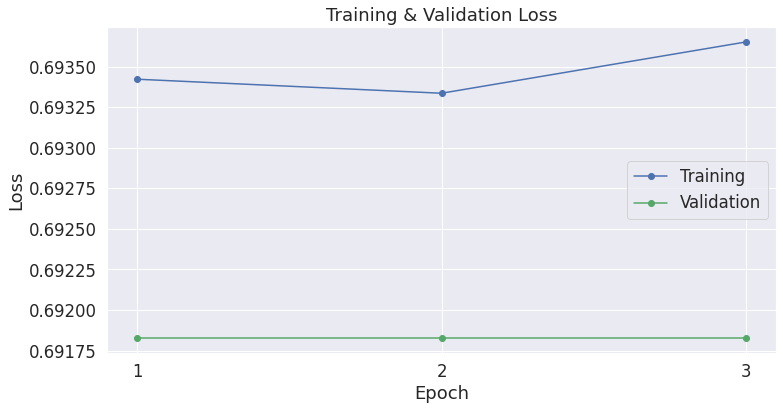

In [0]:
# Visualize training stats
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### TO_DO: change epoch number
plt.xticks([i + 1 for i in range(epochs)])

plt.show()

# Testing

In [0]:
print('Predicting labels for {:,} test sentences...'.format(len(test_dl) * batch_size))

model.eval()

total_accuracy_test = 0

for batch in test_dl:
        
    # unpack current batch's input and labels
    cur_input_ids = batch[0].to(device)
    cur_input_mask = batch[1].to(device)
    cur_labels = batch[2].to(device)

    # no need to calculate and trace gradient
    with torch.no_grad():
        loss, logits = model(cur_input_ids,
                            token_type_ids=None,
                            attention_mask=cur_input_mask,
                            labels=cur_labels)
                    
    # no need to calculate prediction & labels in gpu
    # good practice when involves with large-scale dataset
    logits = logits.detach().cpu().numpy()
    label_ids = cur_labels.to('cpu')
        
    # calculate this batch's accuracy & loss and accumulate with other 
    # batches' accuracies & loss
    total_accuracy_test += get_accuracy_hamming_loss(logits, label_ids)
        

print('Testing Accuracy: {:.2f}'.format(total_accuracy_test/len(test_dl)))
print('Testing Completed')


Predicting labels for 1,472 test sentences...
Testing Accuracy: 0.87
Testing Completed
